In [1]:

### Classic VAE
###
############################################################

from __future__ import print_function
import h5py as h5
import numpy as np
import numba
import sklearn
import tensorflow as tf

print ("Numpy      ver. ", np.__version__)
print ("Numba      ver. ", numba.__version__)  ##  optimize numpy?!?
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)

import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

tf.reset_default_graph()

from tensorflow.python.client import device_lib
print( [ x.name for x in device_lib.list_local_devices() ] )


/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Numpy      ver.  1.15.4
Numba      ver.  0.41.0
H5Py       ver.  2.7.1
SKLearn    ver.  0.19.2
TensorFlow ver.  1.12.0
[u'/device:CPU:0', u'/device:XLA_GPU:0', u'/device:XLA_CPU:0', u'/device:GPU:0', u'/device:GPU:1']


In [2]:
#### Load waveform data
H5_FILE="white_h_8192_dm2.h5"
RATE=8192
H5_FILE="white_h_4096_dm2.h5"
RATE=4096

#!wget http://grqc.ncts.ncku.edu.tw/~lincy/GWDA/white_h_4096_dm2.h5
#!ls


/home/lincy/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# of whiten waveform for each set:  685


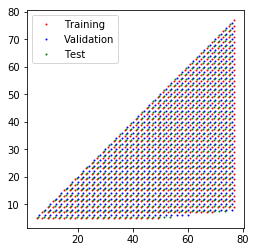

In [3]:
#### Now, visualize the dataset 
import h5py as h5
import matplotlib.pyplot as plt
%matplotlib inline

f = h5.File(H5_FILE,'r')
m1t = f['train_m1']
m2t = f['train_m2']
m1v = f['val_m1']
m2v = f['val_m2']
m1s = f['test_m1']
m2s = f['test_m2']

plt.figure(figsize=(4,4))
plt.plot(m2t, m1t, 'r.', markersize=2, label="Training")
plt.plot(m2v, m1v, 'b.', markersize=2, label="Validation")
plt.plot(m2s, m1s, 'g.', markersize=2, label="Test")
plt.axes().set_aspect('equal')
plt.legend()
#plt.show()
#plt.savefig("VAE_tpl.png")

print ("# of whiten waveform for each set: ", len(f['train_hp']))

f.close()

Make toy data.


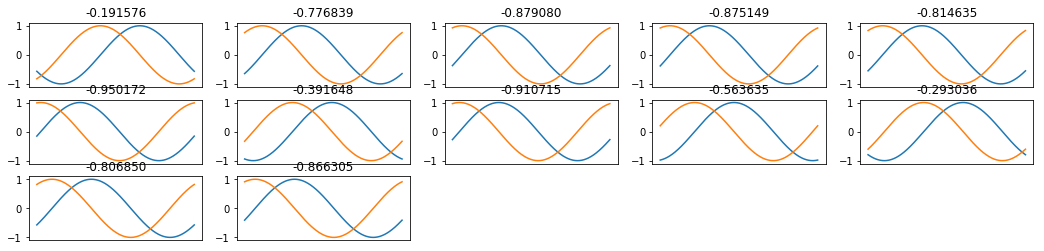

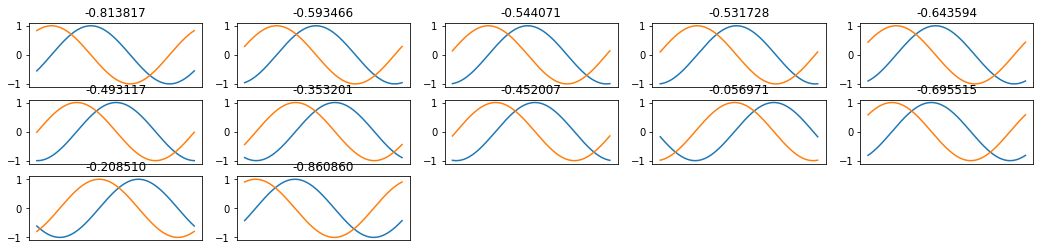

(100, 2, 4096)
(50, 2, 4096)
(50, 2, 4096)
(100, 2)
(50, 2)
(50, 2)
-0.9999999931549273 0.9999998747029554


In [4]:
###
###  Prepare data: extract, transform, load (ETL)
###
import time
#from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

####  EDIT HERE ####
NTYPE = 5    ### Number of toy data type.
z_dim = 2     ### latent neuron
y_dim = 2     ### constraint neuron
batch_size = 32    ### We need it defined here since conv1d_transpose need a static input dimension.

h_dim = 512
TBOARD = False

####################

_NOISE_COPY_ = 1
class GWInject():
    def _add_noise(self, tag, A, nc):
        var = self.f[tag]
        NX = len(var)
        NN = nc * NX
        noise = np.random.normal(0,1,(NN,self.srate))    
        X     = np.random.normal(0,1,(NX,self.srate))  + A * var[:NX,:]      
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)         
                plt.plot(X[i,:])
                plt.plot(A * var[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        X = np.vstack( (noise, X )  ).astype(np.float32)
        Y = np.array([0]*NN + [1]*NX).astype(np.float32).reshape(-1,1)
        #return shuffle(X, Y, random_state=0)
        return X, Y
    
    def __init__(self, fname, plot=0):
        self.fname = fname
        self.plot = plot
        self.f = h5.File(fname, "r")
        self.srate = self.f.attrs.get('srate')   ##4096/ 8192
        print(self.srate, self.f.attrs.get('merger_idx'))
        
    def __exit__(self):
        self.f.close()
        
    def get_train_set(self, A=1.0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/train_hp', A, nc = nc)
        return X, Y
    def get_val_set(self, A=1.0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/val_hp', A, nc = nc)
        return X, Y
    def get_test_set(self, A=1.0):
        X, Y = self._add_noise('/test_hp', A, nc = _NOISE_COPY_)
        return X, Y
      
    def getdata(self, tag='/train', A=1.0):
        X1 = A*np.array(self.f[tag+'_hp'])  #.astype(np.float32)
        X2 = A*np.array(self.f[tag+'_hc'])  #.astype(np.float32)
        
        Y  = np.vstack(( self.f[tag+'_m1'],self.f[tag+'_m2'] )).astype(np.float32)
        print (np.max(Y))
        Y  = (Y / 80. -0.5)*2
        
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X1)):
                plt.subplot(3,5,i+1)         
                plt.plot(X1[i,:])
                plt.title("m=(%.1f, %.1f)"%(Y[0,i],Y[1,i]))
                plt.xticks([])
                if (i > 13): break
            plt.show()
            
        return X1,X2,np.transpose(Y)
        #return np.hstack((X1, X2)), Y

    ###  reduced set of GW    
    def getdata2(self, tag='/train', A=1.0):
        SKIP=40
        X1 = A*np.array(self.f[tag+'_hp'][::SKIP,])  #.astype(np.float32)
        X2 = A*np.array(self.f[tag+'_hc'][::SKIP,])  #.astype(np.float32)
        
        #Mt = np.array(self.f[tag+'_m1']) + np.array(self.f[tag+'_m2'])
        #Mq = np.array(self.f[tag+'_m1'])*np.array(self.f[tag+'_m2']) / Mt        
        #Mt = ( (Mt - np.min(Mt))/ (np.max(Mt) - np.min(Mt)) -0.5 ) *2
        #Mq = ( (Mq - np.min(Mq))/ (np.max(Mq) - np.min(Mq)) -0.5 ) *2
        #Y  = np.vstack(( Mt[::SKIP], Mq[::SKIP] )).astype(np.float32)
        
        Y  = np.vstack(( self.f[tag+'_m1'][::SKIP], self.f[tag+'_m2'][::SKIP] )).astype(np.float32)
        Y  = (Y / 80. -0.5)*2
        
        X1 = np.tile( X1, (SKIP,1) )
        X2 = np.tile( X2, (SKIP,1) )
        Y =  np.tile( Y,  (1, SKIP) )
        
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X1)):
                plt.subplot(3,5,i+1)         
                plt.plot(X1[i,:])
                plt.title("m=(%.1f, %.1f)"%(Y[0,i],Y[1,i]))
                plt.xticks([])
                if (i > 13): break
            plt.show()
            
        return X1,X2,np.transpose(Y)
        #return np.hstack((X1, X2)), Y

#tmp = GWInject(H5_FILE, plot=1)
#AMP = 0.87
#X,Y,_ = tmp.getdata2('/train', A=AMP)  
    
class Toydata():
    def __init__(self, ntype):
        self.ntype = ntype
        print("Make toy data.")
    
    def get_sin(self, A=1.0, N=700, PLOT=0):
        x = np.linspace(0,2*np.pi,RATE)
        y = np.random.uniform(0,np.pi,N)
        xx, yy = np.meshgrid(x, y, sparse=True)
        X1 = A*(np.sin(xx - yy))
        X2 = A*(np.cos(xx - yy))     #.astype(np.float32)
        
        #ynor = y / np.max(y)   ## normalize
        ynor = ( ( y/(2*np.pi)) - 0.5 ) *2   ## normalize
        
        Y  = np.vstack(( ynor, ynor )).astype(np.float32)
        
        if PLOT:
            plt.figure(figsize=(18,4))
            for i in range(0,len(X1)):
                idx=i
                plt.subplot(3,NTYPE,i+1)         
                plt.plot(X1[idx,:])
                plt.plot(X2[idx,:])
                plt.title("%f"%(Y[0,idx]))
                plt.xticks([])
                if (i > NTYPE*2): break
            plt.show()
            
        return X1,X2,np.transpose(Y)

    def get_singauss(self, f0=10, f1=30, w=1, A=1.0, COPY=50, PLOT=0):
        x = np.linspace(0,2*np.pi,RATE)
        y = np.tile( np.linspace(f0,f1,NTYPE)[:] , COPY)
        xx, yy = np.meshgrid(x, y, sparse=True)
        X1 = A*(np.sin(yy*xx)*np.exp(-((xx-1.5*np.pi)/w)**2))
        X2 = A*(np.cos(yy*xx)*np.exp(-((xx-1.5*np.pi)/w)**2))     #.astype(np.float32)
        
        #ynor = y / np.max(y)   ## normalize
        ynor = ( (y-np.min(y)) / (np.max(y)-np.min(y)) - 0.5 ) *2   ## normalize
        
        Y  = np.vstack(( ynor, ynor )).astype(np.float32)
        
        if PLOT:
            plt.figure(figsize=(18,4))
            for i in range(0,len(X1)):
                idx=i
                plt.subplot(3,NTYPE,i+1)         
                plt.plot(X1[idx,:], 'b')
                plt.plot(X2[idx,:], 'r')
                plt.title("%f"%(Y[0,idx]))
                plt.xticks([])
                if (i > NTYPE*2): break
            plt.show()
            
        return X1,X2,np.transpose(Y)
    
    
data = Toydata(ntype=NTYPE)
Xt1,Xt2,Yt = data.get_sin(N=100, PLOT=1)
Xv1,Xv2,Yv = data.get_sin(N=50, PLOT=1)  
Xs1,Xs2,Ys = data.get_sin(N=50, PLOT=0)  

Xt = np.reshape( np.hstack((Xt1,Xt2)), (-1, 2, RATE) )
Xv = np.reshape( np.hstack((Xv1,Xv2)), (-1, 2, RATE) )
Xs = np.reshape( np.hstack((Xs1,Xs2)), (-1, 2, RATE) )

print (Xt.shape)
print (Xv.shape)
print (Xs.shape)
print (Yt.shape)
print (Yv.shape)
print (Ys.shape)

print( np.min(Xv[10:11,:]), np.max(Xv[10:11,:]) )

In [188]:
########
########  Original VAE
########
tf.reset_default_graph()

RATE = 4096
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

def getDenseLayer(input_layer,weight,bias,activation=None):
    x = tf.add(tf.matmul(input_layer,weight),bias)
    if activation: x = activation(x)
    return x

## 
IDEV = 0.1
CH = [2,16,32,64]
#CH = [2,8,16,32]
K  = [16,8,8]
#K  = [8,4,4]

# =============================== Prepare variable ======================================
X  = tf.placeholder(tf.float32, shape=[None, CH[0], RATE])
c  = tf.placeholder(tf.float32, shape=[None, y_dim])
z  = tf.placeholder(tf.float32, shape=[None, z_dim])
lr = tf.placeholder(tf.float32, shape=[])

we1 = tf.Variable(tf.truncated_normal( shape=[ K[0], CH[0], CH[1] ], stddev=IDEV), dtype=tf.float32, name="we1" ) ##(?, 1024, 16)
we2 = tf.Variable(tf.truncated_normal( shape=[ K[1], CH[1], CH[2] ], stddev=IDEV), dtype=tf.float32, name="we2" ) ##(?,  256, 32)
we3 = tf.Variable(tf.truncated_normal( shape=[ K[2], CH[2], CH[3] ], stddev=IDEV), dtype=tf.float32, name="we3" ) ##(?,   64, 64)
wef1  = tf.Variable(tf.truncated_normal( shape=[ CH[3]*64,            256 ], stddev=IDEV), dtype=tf.float32, name="wef1" )
wef2m = tf.Variable(tf.truncated_normal( shape=[      256+y_dim,    z_dim ], stddev=IDEV), dtype=tf.float32, name="wef2m" )
wef2s = tf.Variable(tf.truncated_normal( shape=[      256+y_dim,    z_dim ], stddev=IDEV), dtype=tf.float32, name="wef2s" )
wdf2  = tf.Variable(tf.truncated_normal( shape=[    z_dim+y_dim,      256 ], stddev=IDEV), dtype=tf.float32, name="wdf2" )
wdf1  = tf.Variable(tf.truncated_normal( shape=[            256, CH[3]*64 ], stddev=IDEV), dtype=tf.float32, name="wdf1" )

bef1  = tf.Variable(tf.zeros( shape=[      256 ]), dtype=tf.float32, name="bef1" )
bef2m = tf.Variable(tf.zeros( shape=[    z_dim ]), dtype=tf.float32, name="bef2m" )
bef2s = tf.Variable(tf.zeros( shape=[    z_dim ]), dtype=tf.float32, name="bef2s" )
bdf2  = tf.Variable(tf.zeros( shape=[      256 ]), dtype=tf.float32, name="bdf2" )
bdf1  = tf.Variable(tf.zeros( shape=[ CH[3]*64 ]), dtype=tf.float32, name="bdf1" )

wd3 = tf.Variable(tf.truncated_normal( shape=we3.shape,     stddev=IDEV), dtype=tf.float32, name="wd3" )
wd2 = tf.Variable(tf.truncated_normal( shape=we2.shape,     stddev=IDEV), dtype=tf.float32, name="wd2" )
wd1 = tf.Variable(tf.truncated_normal( shape=we1.shape,     stddev=IDEV), dtype=tf.float32, name="wd1" )

if TBOARD: 
    tf.summary.histogram('we2', we2)
    tf.summary.histogram('we3', we3)

# =============================== Q(z|X) : proposed encoder ======================================
def Q(X, c):
    h1 = tf.nn.conv1d(X,  we1, stride=4, padding="SAME", data_format="NCW") ##(1, 1024, 16)
    h1 = tf.math.atan(h1)
    h2 = tf.nn.conv1d(h1, we2, stride=4, padding="SAME", data_format="NCW") ##(1, 256, 32)
    h2 = tf.math.atan(h2)
    h3 = tf.nn.conv1d(h2, we3, stride=4, padding="SAME", data_format="NCW") ##(1, 64, 64)
    h3 = tf.math.atan(h3)
        
    fclact = tf.math.atan
    fclact = tf.nn.relu
    fclact = tf.nn.sigmoid
    h4       = tf.reshape(h3, [-1,  CH[3]*64 ] )
    h5       = getDenseLayer(h4,  wef1,  bef1, activation=tf.nn.sigmoid)
    h5       = tf.concat(axis=1, values=[h5,c])
    z_mu     = getDenseLayer(h5, wef2m, bef2m, activation=None)
    z_logvar = getDenseLayer(h5, wef2s, bef2s, activation=tf.nn.sigmoid)

    if TBOARD: 
        tf.summary.histogram('h', h)
    
    return z_mu, z_logvar   ### = ln rho^2

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    #return mu + tf.sqrt(log_var) * eps         ###  for = sigma^2
    return (mu + tf.exp(log_var / 2) * eps)     ###  for = log(sigma^2)

# =============================== P(X|z) : decoder ======================================
def P(z, c, NB):
    inputs = tf.concat(axis=1, values=[z,c])
    
    fclact = tf.math.atan
    fclact = tf.nn.relu
    fclact = tf.nn.sigmoid
    g4      = getDenseLayer(inputs, wdf2, bdf2, activation=tf.nn.sigmoid)
    g4      = getDenseLayer(g4,     wdf1, bdf1, activation=tf.nn.relu)

    g3  = tf.reshape(g4, [-1, CH[3], 64 ])
    g2  = tf.contrib.nn.conv1d_transpose(g3, wd3, stride=4, output_shape=[NB,  CH[2], 256], padding="SAME", data_format="NCW")
    g2  = tf.math.atan(g2)
    g1  = tf.contrib.nn.conv1d_transpose(g2, wd2, stride=4, output_shape=[NB,  CH[1], 1024], padding="SAME", data_format="NCW")
    g1  = tf.math.atan(g1)
    logits = tf.contrib.nn.conv1d_transpose(g1, wd1, stride=4, output_shape=[NB, CH[0], RATE], padding="SAME", data_format="NCW")
    
    #prob = tf.nn.sigmoid(logits)
    #prob = tf.math.tanh(logits)
    prob = logits
    
    return prob   ####, prob #logits

# =============================== TRAINING ====================================
z_mu, z_logvar = Q(X, c)
z_sample  = sample_z(z_mu, z_logvar)
logits    = P(z_sample, c, batch_size)

if TBOARD: 
    tf.summary.histogram('z_logvar', z_logvar)
    tf.summary.histogram('logits', logits)

# Sampling from random z
X_ntype = P(z, c, NTYPE)    ###  generation
X_one   = P(z, c, 1)    ###  generation

###  ========= E[log P(X|z)]
#recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
recon_loss = tf.reduce_sum(  tf.reduce_sum( tf.pow(X - logits,2), axis=1)  )   ### axis=1 for each batch sample
###  ========= D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
#kl_loss = tf.reduce_sum( tf.pow( 0.5*tf.reduce_sum( z_logvar + z_mu**2 - 1. - tf.log(z_logvar), 1), 2 ) )    ### for sigma^2
kl_loss = tf.reduce_sum(  tf.pow(  0.5*tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1),2 )  )    ### for ln(sigma^2)
###  ========  total loss
vae_loss = recon_loss + kl_loss
#vae_loss = recon_loss
solver = tf.train.AdamOptimizer(learning_rate=lr, epsilon=1e-2).minimize(vae_loss)

mean_loss, mean_loss_op             = tf.metrics.mean(vae_loss, name="loss")
mean_kl_loss, mean_kl_loss_op       = tf.metrics.mean(kl_loss, name="kl_loss")
mean_recon_loss, mean_recon_loss_op = tf.metrics.mean(recon_loss, name="recon_loss")

if TBOARD: 
    tf.summary.scalar('mean_loss', mean_loss)
    tf.summary.scalar('mean_recon_loss', mean_recon_loss)
    tf.summary.scalar('mean_kl_loss', mean_kl_loss)

    ###tf.summary.histogram('recon_loss', recon_loss)
    ###tf.summary.histogram('kl_loss', kl_loss)



In [189]:
!rm -rf /tmp/lin/.tensorboard
COUNTER = 0

#### Print all vriables
### check all variables
if 1:
    vars = 0
    for v in tf.global_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Whole size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.global_variables()) ) )

    vars = 0
    for v in tf.trainable_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Model size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.trainable_variables()) ) )

    vars = 0
    for v in tf.local_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Local var size: %.3f Bytes | Var # : %d" % (8*vars, len(tf.local_variables()) ) )

<tf.Variable 'we1:0' shape=(16, 2, 16) dtype=float32_ref>
<tf.Variable 'we2:0' shape=(8, 16, 32) dtype=float32_ref>
<tf.Variable 'we3:0' shape=(8, 32, 64) dtype=float32_ref>
<tf.Variable 'wef1:0' shape=(4096, 256) dtype=float32_ref>
<tf.Variable 'wef2m:0' shape=(258, 2) dtype=float32_ref>
<tf.Variable 'wef2s:0' shape=(258, 2) dtype=float32_ref>
<tf.Variable 'wdf2:0' shape=(4, 256) dtype=float32_ref>
<tf.Variable 'wdf1:0' shape=(256, 4096) dtype=float32_ref>
<tf.Variable 'bef1:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'bef2m:0' shape=(2,) dtype=float32_ref>
<tf.Variable 'bef2s:0' shape=(2,) dtype=float32_ref>
<tf.Variable 'bdf2:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'bdf1:0' shape=(4096,) dtype=float32_ref>
<tf.Variable 'wd3:0' shape=(8, 32, 64) dtype=float32_ref>
<tf.Variable 'wd2:0' shape=(8, 16, 32) dtype=float32_ref>
<tf.Variable 'wd1:0' shape=(16, 2, 16) dtype=float32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() 

In [190]:
### 
### begin session
###
### Tensorboard
import math
import random

# Config to turn on JIT compilation
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1

### Session
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
merged = tf.summary.merge_all()

saver = tf.train.Saver()

N = Xt.shape[0]


Iter:    0  Loss: 120076.773 re=    119424 kl=   652.331  Time:   0.0s LR=0.005


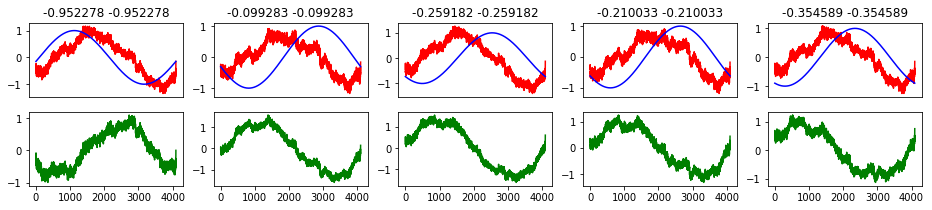

Iter:  100  Loss:   3145.458 re=   2214.25 kl=   931.211  Time:   2.5s LR=0.005
Iter:  200  Loss:   1319.034 re=   1068.77 kl=   250.265  Time:   4.2s LR=0.005
Iter:  300  Loss:    782.132 re=   599.899 kl=   182.233  Time:   5.9s LR=0.005
Iter:  400  Loss:   1205.304 re=   1098.86 kl=    106.44  Time:   7.5s LR=0.005
Iter:  500  Loss:    197.368 re=   138.867 kl=   58.5012  Time:   9.3s LR=0.005
Iter:  600  Loss:    234.057 re=   195.259 kl=    38.798  Time:  11.0s LR=0.005
Iter:  700  Loss:    238.557 re=   203.385 kl=   35.1723  Time:  12.7s LR=0.005
Iter:  800  Loss:    541.084 re=    519.69 kl=   21.3943  Time:  14.4s LR=0.005
Iter:  900  Loss:    203.325 re=   193.909 kl=   9.41577  Time:  16.1s LR=0.005
Iter: 1000  Loss:     90.849 re=   76.9949 kl=   13.8541  Time:  17.9s LR=0.0005


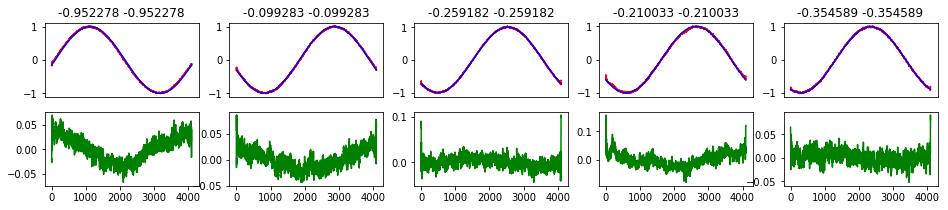

Iter: 1100  Loss:     75.456 re=   63.3489 kl=   12.1074  Time:  20.3s LR=0.0005
Iter: 1200  Loss:     73.907 re=    63.252 kl=   10.6547  Time:  21.8s LR=0.0005
Iter: 1300  Loss:     41.389 re=   32.1317 kl=   9.25683  Time:  23.5s LR=0.0005
Iter: 1400  Loss:     42.088 re=   34.3499 kl=   7.73777  Time:  25.2s LR=0.0005
Iter: 1500  Loss:     38.232 re=   31.2678 kl=    6.9643  Time:  27.0s LR=0.0005
Iter: 1600  Loss:     32.558 re=   26.6685 kl=   5.88914  Time:  28.7s LR=0.0005
Iter: 1700  Loss:     31.992 re=   26.8744 kl=   5.11779  Time:  30.4s LR=0.0005
Iter: 1800  Loss:     40.034 re=   35.8026 kl=   4.23185  Time:  32.1s LR=0.0005
Iter: 1900  Loss:     25.826 re=   22.3816 kl=   3.44429  Time:  33.9s LR=0.0005
Iter: 2000  Loss:     25.372 re=   22.3554 kl=   3.01661  Time:  35.6s LR=0.0005


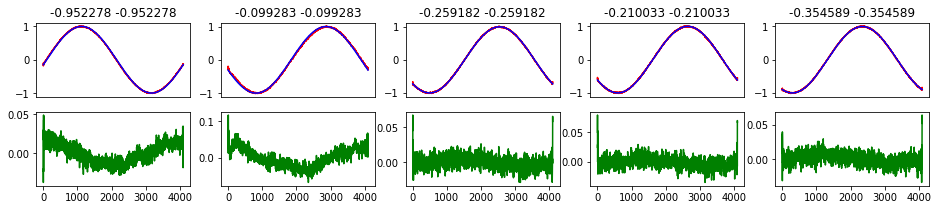

Iter: 2100  Loss:     23.242 re=   20.8656 kl=   2.37666  Time:  38.0s LR=0.0005
Iter: 2200  Loss:     20.188 re=   18.2147 kl=    1.9729  Time:  39.8s LR=0.0005
Iter: 2300  Loss:     19.103 re=   17.4862 kl=   1.61726  Time:  41.5s LR=0.0005
Iter: 2400  Loss:     16.529 re=   15.2521 kl=   1.27655  Time:  43.3s LR=0.0005
Iter: 2500  Loss:     12.957 re=   12.0193 kl=  0.937848  Time:  45.0s LR=0.0005
Iter: 2600  Loss:     12.642 re=   11.7889 kl=  0.853301  Time:  46.8s LR=0.0005
Iter: 2700  Loss:     14.027 re=   13.3077 kl=  0.719189  Time:  48.5s LR=0.0005
Iter: 2800  Loss:     10.122 re=   9.50546 kl=  0.616278  Time:  50.2s LR=0.0005
Iter: 2900  Loss:      9.554 re=   8.96706 kl=  0.587438  Time:  51.9s LR=0.0005
Iter: 3000  Loss:     13.087 re=   12.5889 kl=  0.497731  Time:  53.6s LR=5e-05


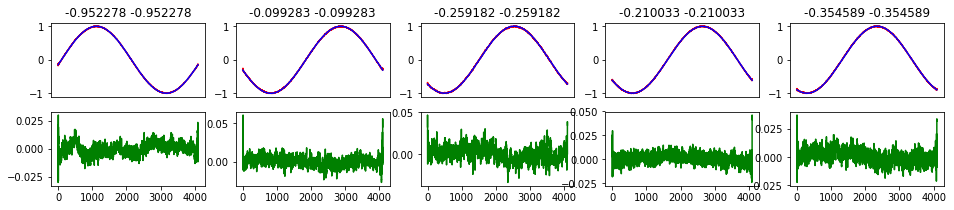

Iter: 3100  Loss:      8.206 re=   7.72336 kl=  0.482226  Time:  56.3s LR=5e-05
Iter: 3200  Loss:      7.917 re=   7.44462 kl=  0.472112  Time:  58.1s LR=5e-05
Iter: 3300  Loss:      8.819 re=   8.37168 kl=  0.447119  Time:  59.9s LR=5e-05
Iter: 3400  Loss:      8.434 re=   7.99759 kl=  0.436023  Time:  61.8s LR=5e-05
Iter: 3500  Loss:      6.937 re=   6.51161 kl=  0.425289  Time:  63.6s LR=5e-05
Iter: 3600  Loss:      6.406 re=   5.99757 kl=  0.407932  Time:  65.5s LR=5e-05
Iter: 3700  Loss:      6.965 re=   6.59672 kl=  0.367799  Time:  67.3s LR=5e-05
Iter: 3800  Loss:      7.528 re=   7.18499 kl=  0.343486  Time:  68.9s LR=5e-05
Iter: 3900  Loss:      6.830 re=    6.5101 kl=  0.320021  Time:  70.7s LR=5e-05
Iter: 4000  Loss:      7.318 re=    7.0129 kl=  0.304892  Time:  72.4s LR=5e-05


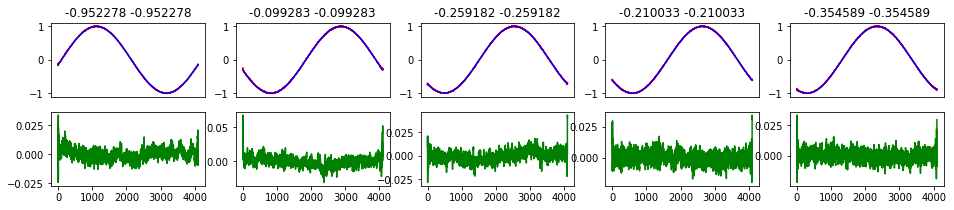

Iter: 4100  Loss:      5.927 re=   5.64015 kl=  0.287058  Time:  75.1s LR=5e-05
Iter: 4200  Loss:      5.927 re=   5.65377 kl=  0.273558  Time:  76.7s LR=5e-05
Iter: 4300  Loss:      6.580 re=   6.31208 kl=  0.267984  Time:  78.3s LR=5e-05
Iter: 4400  Loss:      5.469 re=   5.19526 kl=  0.274079  Time:  79.9s LR=5e-05
Iter: 4500  Loss:      5.613 re=   5.39486 kl=  0.218176  Time:  81.6s LR=5e-05
Iter: 4600  Loss:      5.379 re=   5.16769 kl=  0.210896  Time:  83.2s LR=5e-05
Iter: 4700  Loss:      5.320 re=   5.11676 kl=  0.203308  Time:  84.8s LR=5e-05
Iter: 4800  Loss:      4.409 re=   4.22142 kl=  0.187671  Time:  86.4s LR=5e-05
Iter: 4900  Loss:      5.118 re=     4.946 kl=  0.172189  Time:  88.1s LR=5e-05
Iter: 5000  Loss:      4.898 re=    4.7346 kl=  0.163897  Time:  89.7s LR=1e-05


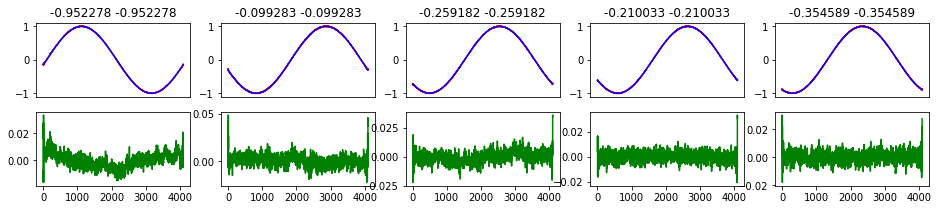

Iter: 5100  Loss:      4.927 re=    4.7655 kl=  0.161536  Time:  92.2s LR=1e-05
Iter: 5200  Loss:      5.497 re=   5.33903 kl=  0.157481  Time:  93.8s LR=1e-05
Iter: 5300  Loss:      4.748 re=   4.59116 kl=  0.157078  Time:  95.5s LR=1e-05
Iter: 5400  Loss:      4.734 re=   4.57959 kl=  0.154763  Time:  97.2s LR=1e-05
Iter: 5500  Loss:      4.609 re=   4.45493 kl=  0.153748  Time:  98.9s LR=1e-05
Iter: 5600  Loss:      4.735 re=   4.58271 kl=  0.152179  Time: 100.6s LR=1e-05
Iter: 5700  Loss:      5.073 re=   4.92274 kl=  0.150249  Time: 102.3s LR=1e-05
Iter: 5800  Loss:      5.213 re=   5.06838 kl=  0.144284  Time: 103.9s LR=1e-05
Iter: 5900  Loss:      4.612 re=   4.46794 kl=  0.144043  Time: 105.6s LR=1e-05
Model saved in path: /tmp/lin/vae.ckpt


In [192]:
###############
###############   Training
###############
start_time = time.time()

summary_writer = tf.summary.FileWriter("/tmp/lin/.tensorboard/%04d"%COUNTER)
COUNTER = COUNTER+1

LR = [0.005]*1000 + [0.0005]*2000 + [0.00005]*2000 + [0.00001]*1000 

#saver.restore(sess, "/tmp/lin/vae.ckpt")
#print("Model restored.")

for epoch in range(len(LR)):
    lra = LR[epoch]
    
    summ = loss = re = kl = 0
    index = [i for i in range(N)]   
    #random.shuffle(index)
    
    while len(index)>0:
        index_size = len(index)
        if index_size < batch_size: break;  ### Don't process incomplete batch just because conv1d_transpose require static input dimension
        batch_index = [index.pop() for _ in range(min(batch_size,index_size))]
        
        _, loss, re, kl = sess.run([solver, vae_loss, recon_loss, kl_loss], feed_dict={X: Xt[batch_index,:], c: Yt[batch_index,:], lr:lra })
        #_,_,_,_, summ = sess.run([solver, mean_loss_op, mean_kl_loss_op, mean_recon_loss_op, merged], feed_dict={X: Xt[batch_index,:], c: Yt[batch_index,:], lr:LR})
        #print (loss, re, kl)

    if TBOARD: summary_writer.add_summary(summ, epoch)
    
    if math.isnan(loss):
        print('Iter: %4d  Loss: %10.3f re=%10g kl=%10g  Time: %5.1fs LR=%g' % (epoch, loss, re, kl, time.time()-start_time, lra ))
        assert False, "Nan detecteced !"
    if epoch % 100 == 0:
        print('Iter: %4d  Loss: %10.3f re=%10g kl=%10g  Time: %5.1fs LR=%g' % (epoch, loss, re, kl, time.time()-start_time, lra ))
    if epoch % 1000 == 0:
        
        PO = 0
        SID = 3*NTYPE
        zz = np.random.randn(NTYPE, z_dim)
        samples = sess.run(X_ntype, feed_dict={z: zz, c: np.reshape(Yv[SID:SID+NTYPE],  (NTYPE, 2) ) } )

        fig = plt.figure(figsize=(16, 3))
        gs = gridspec.GridSpec(2, NTYPE)
        ##gs.update(wspace=0.2, hspace=0.15)
        for i, sample in enumerate(samples):
            
            #plt.axis('off')
            ax = plt.subplot(gs[i])
            plt.xticks([], [])
            plt.title("%4f %4f" % (Yv[SID+i,0], Yv[SID+i,1]) )
            plt.plot(sample[PO], 'r')
            plt.plot(Xv[SID+i,PO,:], 'b')

            ax = plt.subplot(gs[i+NTYPE])
            plt.plot(sample[0]-Xv[SID+i,PO,:], 'g')
        plt.show()
        
save_path = saver.save(sess, "/tmp/lin/vae.ckpt")
print("Model saved in path: %s" % save_path)        

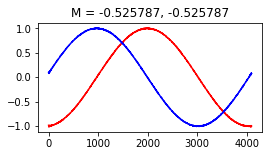

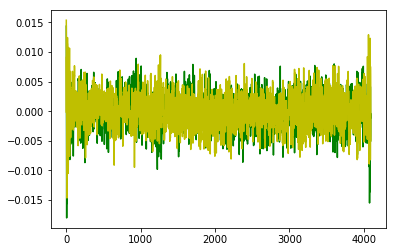

In [195]:

###
###  Test if it can produce an input GW signal
### 
ID = 22

zz = 0*np.random.randn(1, z_dim)
samples = sess.run(X_one, feed_dict={z: zz, c: np.reshape(Ys[ID],  (1, 2) ) } )

plt.figure(figsize=(4, 2))
#plt.figure()
plt.title("M = %f, %f" % (Ys[ID,0],Ys[ID,1]) )
plt.plot(samples[0,0], 'r')
plt.plot(samples[0,1], 'b')
#plt.plot(Xs[ID,:], 'b')
plt.show()
plt.plot(samples[0,0]-Xs[ID,0,:], 'g')
plt.plot(samples[0,1]-Xs[ID,1,:], 'y')
plt.show()


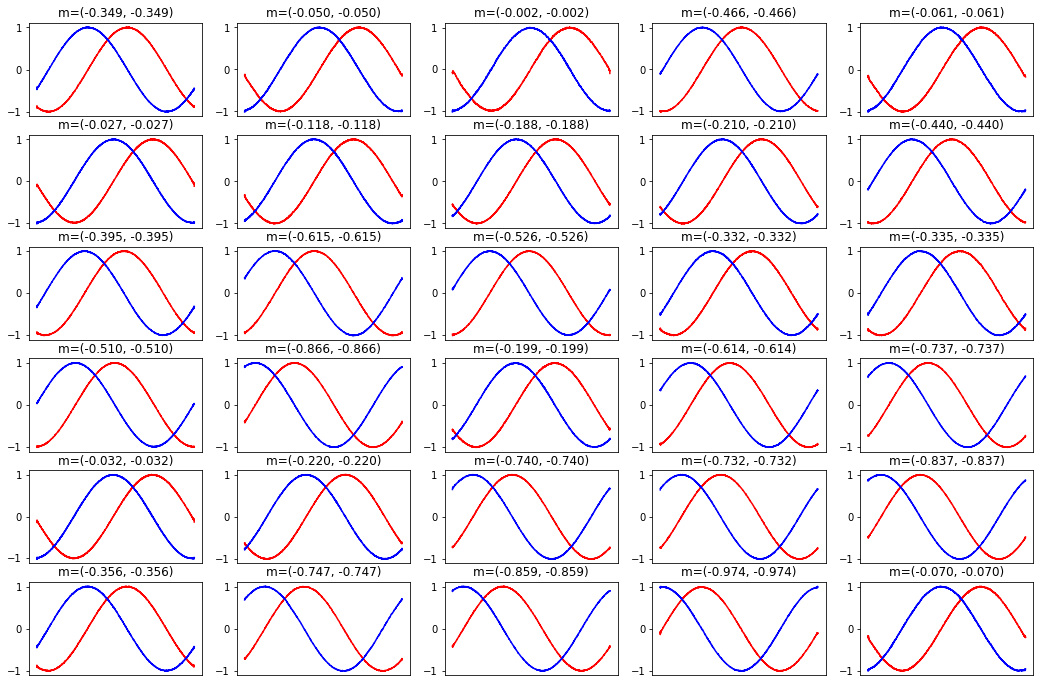

In [196]:
###
###  Test if it can produce many input GW signals
###
import random
N=30
X_testN = P(z, c, N)    ###  generation
test_X = Xs
test_Y = Ys


plt.figure(figsize=(18,12))

ranidx = random.sample(range(len(test_X)), N)   ## test randomly sample
zz = np.random.randn(N, z_dim)
w1 = sess.run(X_testN, feed_dict={z: zz, c: np.reshape(test_Y[ranidx],  (N, 2) ) } )

for i in range(len(ranidx)):
    plt.subplot(6,5,i+1)         
    plt.title("m=(%.3f, %.3f)"%(test_Y[ranidx[i],0],test_Y[ranidx[i],1]))
    
    plt.plot(w1[i,0,:], 'r')
    plt.plot(w1[i,1,:], 'b')
    #plt.plot(test_X[ranidx[i],0,:]-w1[i,0,:], 'g')
    #plt.plot(test_X[ranidx[i],1,:]-w1[i,1,:], 'g')
    plt.xticks([])
   
    if (i > N): break
plt.show()
    
    
#plt.savefig("VAE_testdiff.png")

            
            
    

In [ ]:
###
###  Draw sample over "2D" latent space
###
import random
plt.figure(figsize=(18,17))

NX=11
NUM=NX*NX
####ranidx = random.sample(range(len(Xt)), NUM)   ## test randomly sample

X_testN = P(z, c, NUM)    ###  generation

zz = np.zeros([NUM, z_dim])
zz_x = np.linspace(-20,20,NX)
for ix in range(NX):
 for iy in range(NX):
   zz[ix*NX+iy, 0]=zz_x[ix]
   zz[ix*NX+iy, 1]=zz_x[iy]
   #zz[ix*NX+iy, 3]=zz_x[ix]
   #zz[ix*NX+iy, 4]=zz_x[iy]

#y = np.array( [0, np.pi/5.,  np.pi/2.5,  np.pi/1.2, np.pi ]*150 )
ID=3
w1 = sess.run(X_testN, feed_dict={z: zz, c: np.tile( Ys[ID], (NUM,1) ) } )

for i in range(NUM):
    plt.subplot(NX,NX,i+1)
    #plt.title("m=(%.1f, %.1f)"%(Yt[ranidx[i],0],Yt[ranidx[i],1]))
    
    if (i==NUM/2): plt.plot(w1[i,0], 'g')
    else:          plt.plot(w1[i,0], 'r')

    plt.plot(Xs[ID,0,:], 'b')
    #plt.plot(Xt[ID+1,:], 'b')
    plt.xticks([])
    plt.yticks([])
   
    if (i > NUM): break
plt.show()
#plt.savefig("VAE_testdiff.png")     
            
    

In [176]:
np.tile( Ys[2] , (4,1) )


array([[-0.7179469, -0.7179469],
       [-0.7179469, -0.7179469],
       [-0.7179469, -0.7179469],
       [-0.7179469, -0.7179469]], dtype=float32)